In [46]:
import labelbox as lb
import labelbox.types as lb_types
from API_key_personal import PERSONAL_API_KEY
import os
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

client = lb.Client(PERSONAL_API_KEY)

In [47]:
PROJECT_ID = "clqsva8cw1qk407wn7vpy9xn5"

MODEL_ID = "a33d864f-d185-09b1-3ffc-95dd80b9be15"

In [48]:
#Export data rows that are done
project = client.get_project(PROJECT_ID)

export  = project.export_v2(filters={"workflow_status":"Done"})

export_json = export.result

print(len(export_json))

25985


In [49]:
global_keys = []

for data_row in export_json:
    global_keys.append(data_row["data_row"]["global_key"])

In [50]:
#Get ontology

ontology = project.ontology()

print(ontology.uid)

clqrd0i7l1o6i07x46rcsbi43


In [51]:
#Create model

model = client.get_model(MODEL_ID)

In [52]:
#Create model run

client.enable_experimental = True

config = {
    "image_size": 128
}

model_run = model.create_model_run(name="ANIMAL_ML-V4", config=config)

In [53]:
model_run.upsert_data_rows(global_keys=global_keys)

IMG_SIZE = model_run.get_config()["image_size"]

In [54]:
class_names = []
with open("../animal_names.txt", "r") as file:
    for animal_name in file:
        class_names.append(animal_name.strip())

class_dict = {v:k for (v,k) in enumerate(class_names)}

In [55]:
imgs = []
global_keys = []

for data_row in tqdm(export_json, total=len(export_json)):
    try:
        with open(f'../numpy/{data_row["data_row"]["global_key"]}.npy', "rb") as file:
            img = np.load(file)
            img = Image.fromarray((img*255).astype(np.uint8))
            img = img.resize((IMG_SIZE, IMG_SIZE))
            img = np.asarray(img, dtype=np.float32)/255
            if img.shape != (IMG_SIZE, IMG_SIZE, 3):
                print(img.shape)
                continue
            global_keys.append(data_row["data_row"]["global_key"])
            imgs.append(img)
    except:
        continue




100%|██████████| 25985/25985 [00:12<00:00, 2020.52it/s]


In [56]:
print(np.array(imgs).shape)

(25935, 128, 128, 3)


In [57]:
model: tf.keras.Model = tf.keras.models.load_model("../models/Animal_ML_Model_V4.keras")

probability_mode = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

predictions = probability_mode.predict(np.array(imgs), workers=4, use_multiprocessing=True)

811/811 [==============================] - 22s 26ms/step


[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
dog


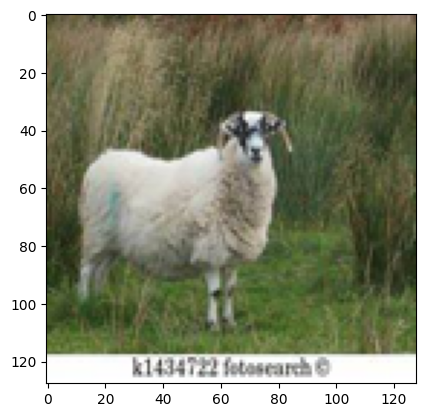

In [58]:
IMG_INDEX = 5000

pred_test = np.argmax(predictions[IMG_INDEX])

print(predictions[IMG_INDEX])

print(class_dict[pred_test])
plt.imshow(imgs[IMG_INDEX])

In [59]:
pred = []
for i,prediction in enumerate(predictions):
    class_index = np.argmax(prediction)
    pred.append(
        lb_types.Label(
        data=lb_types.ImageData(global_key=global_keys[i]),
        annotations=[lb_types.ClassificationAnnotation(
            name="animal_ml_radio",
            value = lb_types.Radio(answer=lb_types.ClassificationAnswer(name = class_dict[class_index], confidence=prediction[class_index]))
        )])
    )
    

In [60]:
print(len(pred))
model_run.add_predictions(
    name="prediction_upload_1",
    predictions=pred
)


25935


<MEAPredictionImport ID: a34117a1-450e-02e9-588e-d0523f1db82a>

In [61]:
model_run.upsert_labels(project_id=project.uid)

True